In [ ]:
%%capture
!pip install qiskit-aer qiskit-ibm-runtime qiskit_experiments pylatexenc quantuminspire snntorch

In [ ]:
python.__version__

In [ ]:
# @title Imports
# from qiskit import QuantumCircuit, Aersimu, execute
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from qiskit import transpile
from qiskit.quantum_info import Statevector
from qiskit.primitives import BackendSampler
from qiskit.circuit import QuantumCircuit
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, utils
from tqdm import tqdm
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen
import pickle
import matplotlib.gridspec as gridspec

if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

J_ROOT = os.readlink('/proc/%s/cwd' % os.environ['JPY_PARENT_PID'])
print(J_ROOT)

!python --version

In [ ]:
# @title Select Backend type
def select_backend(backend_type):
  if backend_type == "Starmon-5":
    import os
    from quantuminspire.credentials import get_authentication
    from quantuminspire.qiskit import QI
    from quantuminspire.credentials import get_token_authentication
    from coreapi.auth import TokenAuthentication
    token = TokenAuthentication('6af0e322481376e6785741e7af617420b671b522', scheme="token")
    QI.set_authentication(token)
    auth = get_token_authentication()

    print(QI.backends())
    backend = QI.get_backend('Starmon-5')

  elif backend_type == "AerSimulator":
    # Use AerSimulator
    from qiskit_aer import AerSimulator
    backend = AerSimulator()

    return backend

In [ ]:
# @title Functions to create Quantum circuits
# Define Tetrahedral POVM states as rotation circuits
def povm_circuits(n: int, backend: str):
    # Create circuits that prepare the tetrahedral states
    circuits = []

    if backend == "Starmon-5":
      r = range(1,n+1)
      n = 5
    else:
      r = range(n)

    qc_0 = QuantumCircuit(n)
    qc_1 = QuantumCircuit(n)
    qc_2 = QuantumCircuit(n)
    qc_3 = QuantumCircuit(n)

    for i in r:
      # POVM state |psi_1> = 1/sqrt(3) (|0> + sqrt(2)|1>)
      qc_1.ry(2 * np.arccos(1 / np.sqrt(3)), i)  # Ry rotation to align state

      # POVM state |psi_2> = 1/sqrt(3) (|0> + exp(i2pi/3) sqrt(2)|1>)
      qc_2.ry(2 * np.arccos(1 / np.sqrt(3)), i)
      qc_2.rz(2 * np.pi / 3, i)  # Add phase rotation

      # POVM state |psi_3> = 1/sqrt(3) (|0> + exp(-i2pi/3) sqrt(2)|1>)
      qc_3.ry(2 * np.arccos(1 / np.sqrt(3)), i)
      qc_3.rz(-2 * np.pi / 3, i)  # Add phase rotation

    circuits.append(qc_0)
    circuits.append(qc_1)
    circuits.append(qc_2)
    circuits.append(qc_3)

    return circuits

# Function to create the main circuit to prepare and measure a quantum state
def create_measurement_circuits(state_circuit, povm_circuits, backend: str):
    measurement_circuits = []
    for povm_circ in povm_circuits:
      qc = state_circuit & povm_circ  # Combine the state preparation and POVM rotation
      qc.measure_active() # Measure in computational basis after rotation
      measurement_circuits.append(qc)
    return measurement_circuits

# Example: Create a GHZ state circuit for N qubits
def get_qc_for_n_qubit_GHZ_state(n: int, backend: str) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.

    Args:
        n (int): Number of qubits in the n-qubit GHZ state

    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2 and backend == "Starmon-5":
        qc = QuantumCircuit(5)
        qc.h(1)
        qc.cx(1, 2)
        if n == 3:
          qc.cx(2, 3)

    elif isinstance(n, int) and n >=2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc


In [ ]:
# @title Class: QuantumPOVMDataset
class QuantumPOVMDataset(Dataset):
    """Quantum POVM dataset."""

    def __init__(self, measurement_data, transform=None):
        """
        Arguments:
            measurement_data (list): List of measurement data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.results = measurement_data
        measurements = []
        for r in range(4):
          memory = measurement_data(r)['memory']
          for i in range(len(memory)):
            # Convert hex to binary, remove the '0b' prefix, and pad with leading zeros
            binary_string = bin(int(memory[i], 16))[2:].zfill(n)

            # Convert each binary string into an array of binary digits (0s and 1s)
            binary_digit_arrays = [list(map(np.float32, list(b))) for b in binary_string]
            measurements.extend(binary_digit_arrays)  # Extend the list

        # print("Array of binary digits:", binary_digit_arrays)
        # print(np.reshape(measurements, (-1, 8)).size())
        measurements = np.array(measurements).reshape(-1, 4 * n)
        self.measurements = measurements
        self.transform = transform

    def __len__(self):
        return len(self.measurements)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        name = "POVM concatenated"
        povm = self.measurements[idx]
        sample = {'POVM': povm}

        if self.transform:
            sample = self.transform(sample)

        return sample
    def split_dataset(self, split):
    # Define the dataloader, model, and optimizer
      split_train = int(split[0] * len(self))
      split_test =  int(split[1] * len(self))
      split_val = len(self) - split_train - split_test
      train_indices = list(range(split_train))
      test_indices = list(range(split_train, split_train + split_test))
      val_indices = list(range(split_train + split_test, len(self)))
      train_set = Subset(self, train_indices)
      test_set = Subset(self, test_indices)
      val_set = Subset(self, val_indices)
      train_loader = DataLoader(train_set,
                                batch_size=batch_size,
                                shuffle=shuffle,
                                num_workers=num_workers)
      test_loader = DataLoader(test_set,
                              batch_size=batch_size,
                              shuffle=shuffle,
                              num_workers=num_workers)
      val_loader = DataLoader(val_set,
                              batch_size=batch_size,
                              shuffle=shuffle,
                              num_workers=num_workers)
      return train_loader, test_loader, val_loader

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        povm = sample['POVM']

        return {'POVM': torch.from_numpy(povm)}



In [ ]:
# @title Function to calculate angles in Hilbert space
def calculate_angles(state_vector):
    """
    Calculate the angles theta and phi that correspond to rotations
    from the |0> state to the given quantum state.

    Args:
        state_vector (array-like): The quantum state represented as a vector [a, b],
                                   where |psi> = a|0> + b|1>.

    Returns:
        tuple: (theta, phi) angles in radians.
    """
    # Extract the components of the state vector
    a, b = state_vector

    # Calculate theta and phi
    theta = 2 * np.arccos(np.abs(a))  # Angle for Ry rotation
    phi = np.angle(b) - np.angle(a)   # Angle for Rz rotation

    return theta, phi

# Example state: Let's take a sample state |psi> = (1/√3)|0> + (√2/√3)|1>
# Corresponds to tetrahedral POVM states, e.g., (1/√3, √2/√3)
example_state = [1/np.sqrt(3), np.sqrt(2)/np.sqrt(3)]

# Calculate the angles
theta, phi = calculate_angles(example_state)
print(f"Calculated Angles: theta = {theta:.4f} rad, phi = {phi:.4f} rad")

Calculated Angles: theta = 1.9106 rad, phi = 0.0000 rad


In [ ]:
#@title Plotting Settings
def plot_cur_mem_spk(cur, mem, spk, thr_line=False, vline=False, title=False,
                     ylim_max1=1.25, ylim_max2=1.25, neuron_index=0):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,6), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input current
  ax[0].plot(cur, c="tab:orange")
  ax[0].set_ylim([0, ylim_max1])
  ax[0].set_xlim([0, 200])
  ax[0].set_ylabel("Input Current ($I_{in}$)")
  if title:
    ax[0].set_title(title)

  # Select data for the specified output neuron
  i = torch.remainder(neuron_index, outputs)
  j = neuron_index.div(outputs, rounding_mode="floor")
  # print(j)
  mem = mem[:, j, i].detach()  # Select neuron data from the first batch
  spk= spk[:, j, i].detach()  # Select neuron data from the first batch

  # Plot membrane potential
  ax[1].plot(mem)
  ax[1].set_ylim([0, ylim_max2])
  ax[1].set_ylabel("Membrane Potential ($U_{mem}$)")
  if thr_line:
    ax[1].axhline(y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2)
  plt.xlabel("Time step")

  # Plot output spike using spikeplot
  splt.raster(spk, ax[2], s=400, c="black", marker="|")
  if vline:
    ax[2].axvline(x=vline, ymin=0, ymax=6.75, alpha = 0.15, linestyle="dashed", c="black", linewidth=2, zorder=0, clip_on=False)
  plt.ylabel("Output spikes")
  plt.yticks([])

  plt.show()

def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
  # Generate Plots
  fig, ax = plt.subplots(3, figsize=(8,7), sharex=True,
                        gridspec_kw = {'height_ratios': [1, 1, 0.4]})

  # Plot input spikes
  splt.raster(spk_in[:,0], ax[0], s=0.03, c="black")
  ax[0].set_ylabel("Input Spikes")
  ax[0].set_title(title)

  # Plot hidden layer spikes
  splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s = 0.05, c="black")
  ax[1].set_ylabel("Hidden Layer")

  # Plot output spikes
  splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
  ax[2].set_ylabel("Output Spikes")
  ax[2].set_ylim([0, 10])

  plt.show()

In [ ]:
# @title Class: Model (This is the VAE model)
class Model(torch.nn.Module):
    """ Complete model with encoder (SNN on CPU) and decoder(SNN on Brainscales) """

    def __init__(
            self,
            encoder: torch.nn.Module,
            decoder: torch.nn.Module,
            readout_scale: float = 1.):
        """
        Initialize the model by assigning encoder, network and decoder
        :param encoder: Module to encode input data
        :param network: Network module containing layers and
            parameters / weights
        :param decoder: Module to decode network output
        """
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder

        self.readout_scale = readout_scale

    def reparameterization(self, mean, var):
      std = torch.sqrt(var).to(device)
      eps = torch.randn(std.shape).to(device)

      return mean + eps * std

    def loss_function(self, x_hat, x, mean, log_var):
     # Calculate reconstruction loss (example: MSE)
      reconstruction_loss = nn.MSELoss()(x_hat.reshape(-1), x.reshape(-1))

      # Calculate KL divergence
      kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

      # Combine the losses
      total_loss = reconstruction_loss + kl_divergence
      return total_loss

    def calc_mean_var(self, spk):

      # Calculate mean and variance across time steps
      mean = spk.mean(dim=0)  # Shape: [batch_size, output_size]

      variance = spk.var(dim=0, unbiased=False)  # Shape: [batch_size, output_size]
      # print("spike mean shape per outpu neuron\n", mean.shape)

      return mean, variance

    def plot_spikes(self, spk, mem, cur):

      print(torch.argmax(spk.sum(0)), torch.max(spk.sum(0)), spk.shape)
      print("max spike index\n", torch.remainder(max_spk_index,  2 * 2**n))
      print("spike sum shape per output over all time steps\n",spk.sum(0).shape)
      print("spike sum per output over all time steps\n",spk.sum(0))


      max_spk_index = torch.argmax(spk.sum(0))
      plot_cur_mem_spk(cur.detach().numpy(), mem, spk, thr_line=1,ylim_max1=0.5,
        title="LIF Neuron that spikes the most from the output of the decoder",
                     neuron_index = max_spk_index)


    def forward(self, x):
        spk, mem, cur = self.encoder(x)
        mean, log_var = self.calc_mean_var(spk)
        # self.plot_spikes(spk, mem, cur)

        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        spk, mem = self.decoder(z)

        # print(type(x_hat))

        return spk, mem, cur, mean, log_var


In [ ]:
# @title Class Encoder
class Encoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, beta):
    super().__init__()

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.lif1 = snn.Leaky(beta=beta)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.lif2 = snn.Leaky(beta=beta)

  def forward(self, x):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()

    spk2_rec = []
    mem2_rec = []

    for step in range(num_steps):
      cur1 = self.fc1(x)
      spk1, mem1 = self.lif1(cur1, mem1)

      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)

      spk2_rec.append(spk2)
      mem2_rec.append(mem2)

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0), cur2

In [ ]:
# @title Class: Decoder
class Decoder(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, beta):
    super().__init__()

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.lif1 = snn.Leaky(beta=beta)
    self.fc2 = nn.Linear(hidden_size, output_size)
    self.lif2 = snn.Leaky(beta=beta)

  def forward(self, x):
    mem1 = self.lif1.init_leaky()
    mem2 = self.lif2.init_leaky()

    spk2_rec = []
    mem2_rec = []

    for step in range(num_steps):
      cur1 = self.fc1(x)
      spk1, mem1 = self.lif1(cur1, mem1)

      cur2 = self.fc2(spk1)
      spk2, mem2 = self.lif2(cur2, mem2)

      spk2_rec.append(spk2)
      mem2_rec.append(mem2)

    return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [ ]:
# @title Function to train the Model
def train(model, dataloader, optimizer, device):
  fig = plt.figure(figsize=(12, 6))  # Adjust figure size as needed
  gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])  # 2 columns: graph, loss

  ax1 = plt.subplot(gs[0])  # Existing graph in the first column
  ax1.set_title('Training Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  line, = ax1.plot([], [], 'r-')

  ax2 = plt.subplot(gs[1])  # Loss value in the second column
  ax2.set_title('Current Loss')
  current_loss_text = ax2.text(0.5, 0.5, '',
                               ha='center',
                               va='center',
                               fontsize=12)

  model.train()

  # Initialize lists for storing loss values
  train_loss = []

  # Training loop
  for epoch in range(num_epochs):
      epoch_loss = []
      data = iter(dataloader)
      for sample_batched in tqdm(data):
          sample_batched = sample_batched['POVM'].to(device)
          optimizer.zero_grad()

          # Forward pass
          spk, mem, cur, mean, log_var = model(sample_batched)

          # Calculate loss
          loss = model.loss_function(spk.sum(0), sample_batched, mean, log_var)
          loss.backward()
          optimizer.step()

          # Append current loss
          epoch_loss.append(loss.item())

      # Calculate and store the average loss for the epoch
      avg_epoch_loss = sum(epoch_loss) / len(dataloader)
      print(avg_epoch_loss)
      train_loss.append(avg_epoch_loss)

      # Update the plot
      line.set_xdata(range(len(train_loss)))  # Set x data for the line plot
      current_loss_text.set_text(f'{avg_epoch_loss:.4f}')
      line.set_ydata(train_loss)  # Set y data for the line plot
      ax1.relim()  # Recompute the data limits
      ax1.autoscale_view()  # Rescale the view to the new data limits

      # Clear the output and update the plot in Jupyter Notebook
      clear_output(wait=True)
      display(fig)
      plt.pause(0.01)  # Pause briefly to allow the plot to update

  # Finalize plot display
  plt.ioff()
  plt.show()

  return model

In [ ]:
# @title Function to Test the model
def test(model, dataloader, optimizer, device):
  model.eval()

  # Initialize lists for storing loss values
  test_loss = []

  data = iter(dataloader)
  for sample_batched in tqdm(data):
      sample_batched = sample_batched['POVM'].to(device)
      optimizer.zero_grad()

      # Forward pass
      spk, mem, cur, mean, log_var = model(sample_batched)

      # Calculate loss
      loss = model.loss_function(spk.sum(0), sample_batched, mean, log_var)

      # Append current loss
      test_loss.append(loss)

  test_loss = sum(test_loss) / len(test_loss)

  model.plot_spikes(spk, mem, cur)

  return test_loss

In [ ]:
# @title Functions to run the quantum experiment and create the dataset
def run_quantum_experiment(backend):
  # Create a new circuit with n qubits

  try:
    backendName = backend.name()
    print(backendName)
  except:
    backendName = backend.name
    print(backendName)

  state_circuit = get_qc_for_n_qubit_GHZ_state(n, backendName)
  povm_circuit_list = povm_circuits(n, backendName)

  # Combine state preparation and POVM measurements
  measurement_circuits = create_measurement_circuits(state_circuit,
                                                     povm_circuit_list,
                                                     backendName)

  # Create the QASM insructions and excecute the jobs in a list
  circuits_compiled = transpile(measurement_circuits, backend)
  job = backend.run(circuits_compiled, shots=shots, memory=True)
  result = job.result()
  # print(result)


  return result, circuits_compiled

def create_POVM_dataset(result):

  POVM_dataset = QuantumPOVMDataset(result.data,transform=transforms
                                    .Compose([ToTensor()]))
  # print	(POVM_dataset)
  print(POVM_dataset.measurements.shape)

  return POVM_dataset

def print_circuits_with_counts(circuits_compiled, result):
    # Print circuits and measurement data
    counts = result.get_counts()
    for i, circuit in enumerate(circuits_compiled):
      display(circuit.draw("mpl", style="iqp"))
      # latex_source = circuit.draw("latex_source", style="iqp")
      # print(latex_source)
      print(counts[i])

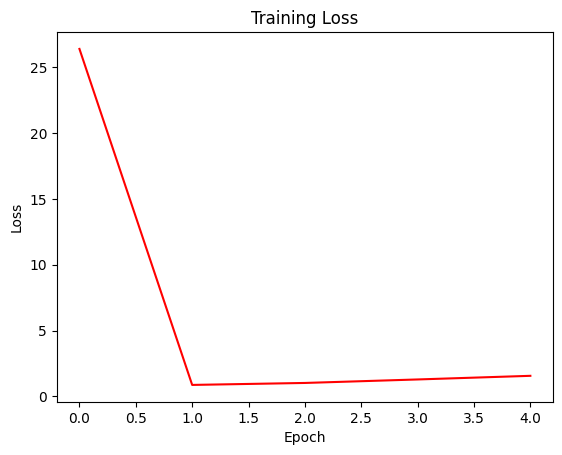

In [ ]:
# @title Main
n = 3 # Amount of qubits
shots = 10e4 # amount of shots taken by the quantum simulator
# Use this to get model and dataset from storage. True if n changes
first_run = False
# Support for "Starmon-5" and "AerSimulator"
backend_type = "AerSimulator"
backend = select_backend(backend_type)

# Define hyperparameters
inputs = 4 * n
hidden = 32 * n
outputs = 2 * 2**n
beta = 0.819
num_steps = 200
num_epochs = 5
learning_rate = 1e-3
batch_size = 2000
num_workers = 0
shuffle = False
split = [0.6, 0.2]

if first_run:
  result, circuits = run_quantum_experiment(backend)
  POVM_dataset = create_POVM_dataset(result)
  with open('POVM_data.pkl', 'wb') as f:
    # Save as a dictionary
    pickle.dump({'dataset': POVM_dataset,
                 'circuits': circuits,
                 'result': result}, f)
else:
  with open('POVM_data.pkl', 'rb') as f:
    data = pickle.load(f)
    POVM_dataset = data['dataset']
    circuits = data['circuits']
    result = data['result']

print_circuits_with_counts(circuits, result)

train_loader, test_loader, val_loader = POVM_dataset.split_dataset(split)

# display (print(train_loader))
encoder = Encoder(inputs, hidden, outputs, beta).to(device)
decoder = Decoder(outputs, hidden, inputs, beta).to(device)
model = Model(encoder, decoder).to(device)
if first_run:
  torch.save(model.state_dict(), "model.pt")
else:
  model.load_state_dict(torch.load("model.pt"))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = train(model, train_loader, optimizer, device)

In [ ]:
test_loss = test(model, test_loader, optimizer, device)
# print(test_loss.item)

 30%|███       | 3/10 [00:11<00:26,  3.79s/it]

In [ ]:
print(test_loss.item())

In [ ]:
def leaky_integrate_and_fire(mem, x, w, beta, threshold=1):
  spk = (mem > threshold) # if membrane exceeds threshold, spk=1, else, 0
  mem = beta * mem + w*x - spk*threshold
  return spk, mem

In [ ]:
# set neuronal parameters
delta_t = torch.tensor(1e-3)
tau = torch.tensor(5e-3)
beta = torch.exp(-delta_t/tau)

print(f"The decay rate is: {beta:.3f}")

In [ ]:
num_steps = 200

# initialize inputs/outputs + small step current input
x = torch.cat((torch.zeros(10), torch.ones(190)*0.5), 0)
mem = torch.zeros(1)
spk_out = torch.zeros(1)
mem_rec = []
spk_rec = []

# neuron parameters
w = 0.4
beta = 0.819

# neuron simulation
for step in range(num_steps):
  spk, mem = leaky_integrate_and_fire(mem, x[step], w=w, beta=beta)
  mem_rec.append(mem)
  spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)
print((x*w).shape, mem_rec.shape, spk_rec.shape)
plot_cur_mem_spk(x*w, mem_rec, spk_rec, thr_line=1,ylim_max1=0.5,
                 title="LIF Neuron Model With Weighted Step Voltage")

In [ ]:
snn.Leaky(beta=0.8)